In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import SimpleITK as sitk
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import timm
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from DataHandler import NoduleDataset

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
BATCH_SIZE = 16
NUM_EPOCHS = 25
LEARNING_RATE = 1e-4
IMAGE_SIZE = 224
NUM_WORKERS = 4
WEIGHT_DECAY = 0.01

# Paths - using pre-split data to avoid leakage
split_base_path = "./nodule_dataset21/cxr_images/proccessed_data/split_data"

train_images_path = os.path.join(split_base_path, "train", "images")
val_images_path = os.path.join(split_base_path, "val", "images")
test_images_path = os.path.join(split_base_path, "test", "images")

train_csv_path = os.path.join(split_base_path, "train", "metadata_train.csv")
val_csv_path = os.path.join(split_base_path, "val", "metadata_val.csv")
test_csv_path = os.path.join(split_base_path, "test", "metadata_test.csv")

In [4]:
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=3),
    transforms.ColorJitter(brightness=0.05, contrast=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Loading metadata...
Original dataset: 5224 samples
Train: 5725 samples
Val: 782 samples
Test: 785 samples
Total (combined): 7292 samples


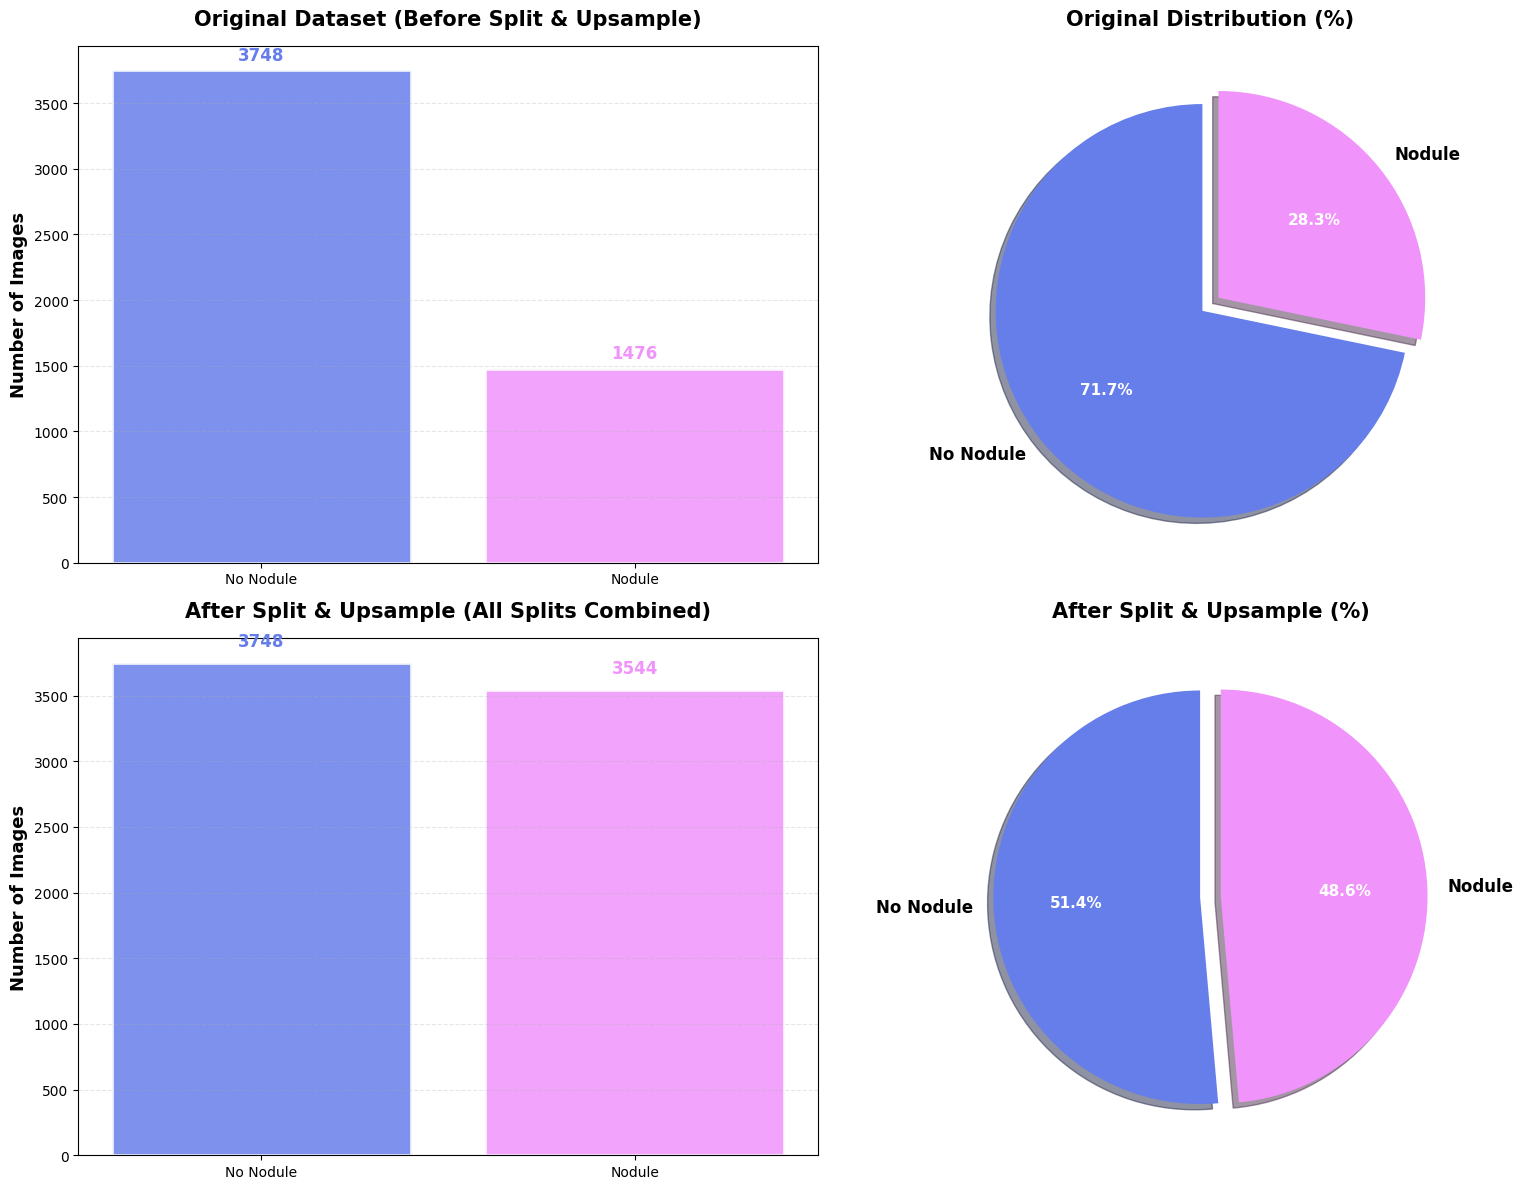


✓ Before/After comparison saved to 'before_after_split_upsample.png'


In [5]:
# %% Load Pre-Split Data

# Also load original data for before/after comparison 
original_csv_path = "./nodule_dataset21/cxr_images/proccessed_data/metadata.csv"

print("Loading metadata...")
train_df = pd.read_csv(train_csv_path)
val_df = pd.read_csv(val_csv_path)
test_df = pd.read_csv(test_csv_path)

# Try to load original data
try:
    original_df = pd.read_csv(original_csv_path)
    has_original = True
    print(f"Original dataset: {len(original_df)} samples")
except:
    has_original = False
    print("Original metadata not found, skipping before/after comparison")

print(f"Train: {len(train_df)} samples")
print(f"Val: {len(val_df)} samples")
print(f"Test: {len(test_df)} samples")

# Combine all splits for total distribution
combined_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
print(f"Total (combined): {len(combined_df)} samples")

# %% Beautiful color palette
color_negative = '#667eea'  # Soft purple
color_positive = '#f093fb'  # Soft pink
colors = [color_negative, color_positive]

# %% Figure 1: Before vs After Upsampling (if original data exists)
if has_original:
    fig1, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig1.patch.set_facecolor('white')
    
    # Original distribution - Bar
    original_counts = original_df['label'].value_counts().sort_index()
    axes[0, 0].bar(['No Nodule', 'Nodule'], original_counts.values, 
                   color=colors, alpha=0.85, edgecolor='white', linewidth=2)
    axes[0, 0].set_ylabel('Number of Images', fontsize=13, fontweight='bold')
    axes[0, 0].set_title('Original Dataset (Before Split & Upsample)', fontsize=15, fontweight='bold', pad=15)
    axes[0, 0].grid(axis='y', alpha=0.3, linestyle='--')
    axes[0, 0].set_facecolor('#ffffff')
    for i, v in enumerate(original_counts.values):
        axes[0, 0].text(i, v + 50, str(v), ha='center', va='bottom', 
                        fontsize=12, fontweight='bold', color=colors[i])
    
    # Original distribution - Pie
    wedges, texts, autotexts = axes[0, 1].pie(original_counts.values, 
                                               labels=['No Nodule', 'Nodule'], 
                                               autopct='%1.1f%%',
                                               colors=colors, 
                                               startangle=90,
                                               explode=(0.05, 0.05),
                                               shadow=True)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(11)
    for text in texts:
        text.set_fontsize(12)
        text.set_fontweight('bold')
    axes[0, 1].set_title('Original Distribution (%)', fontsize=15, fontweight='bold', pad=15)
    
    # After split & upsample - Bar
    combined_counts = combined_df['label'].value_counts().sort_index()
    axes[1, 0].bar(['No Nodule', 'Nodule'], combined_counts.values, 
                   color=colors, alpha=0.85, edgecolor='white', linewidth=2)
    axes[1, 0].set_ylabel('Number of Images', fontsize=13, fontweight='bold')
    axes[1, 0].set_title('After Split & Upsample (All Splits Combined)', fontsize=15, fontweight='bold', pad=15)
    axes[1, 0].grid(axis='y', alpha=0.3, linestyle='--')
    axes[1, 0].set_facecolor('#ffffff')
    for i, v in enumerate(combined_counts.values):
        axes[1, 0].text(i, v + 100, str(v), ha='center', va='bottom', 
                        fontsize=12, fontweight='bold', color=colors[i])
    
    # After split & upsample - Pie
    wedges, texts, autotexts = axes[1, 1].pie(combined_counts.values, 
                                               labels=['No Nodule', 'Nodule'], 
                                               autopct='%1.1f%%',
                                               colors=colors, 
                                               startangle=90,
                                               explode=(0.05, 0.05),
                                               shadow=True)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(11)
    for text in texts:
        text.set_fontsize(12)
        text.set_fontweight('bold')
    axes[1, 1].set_title('After Split & Upsample (%)', fontsize=15, fontweight='bold', pad=15)
    
    plt.tight_layout()
    plt.savefig('before_after_split_upsample.png', dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print("\n✓ Before/After comparison saved to 'before_after_split_upsample.png'")

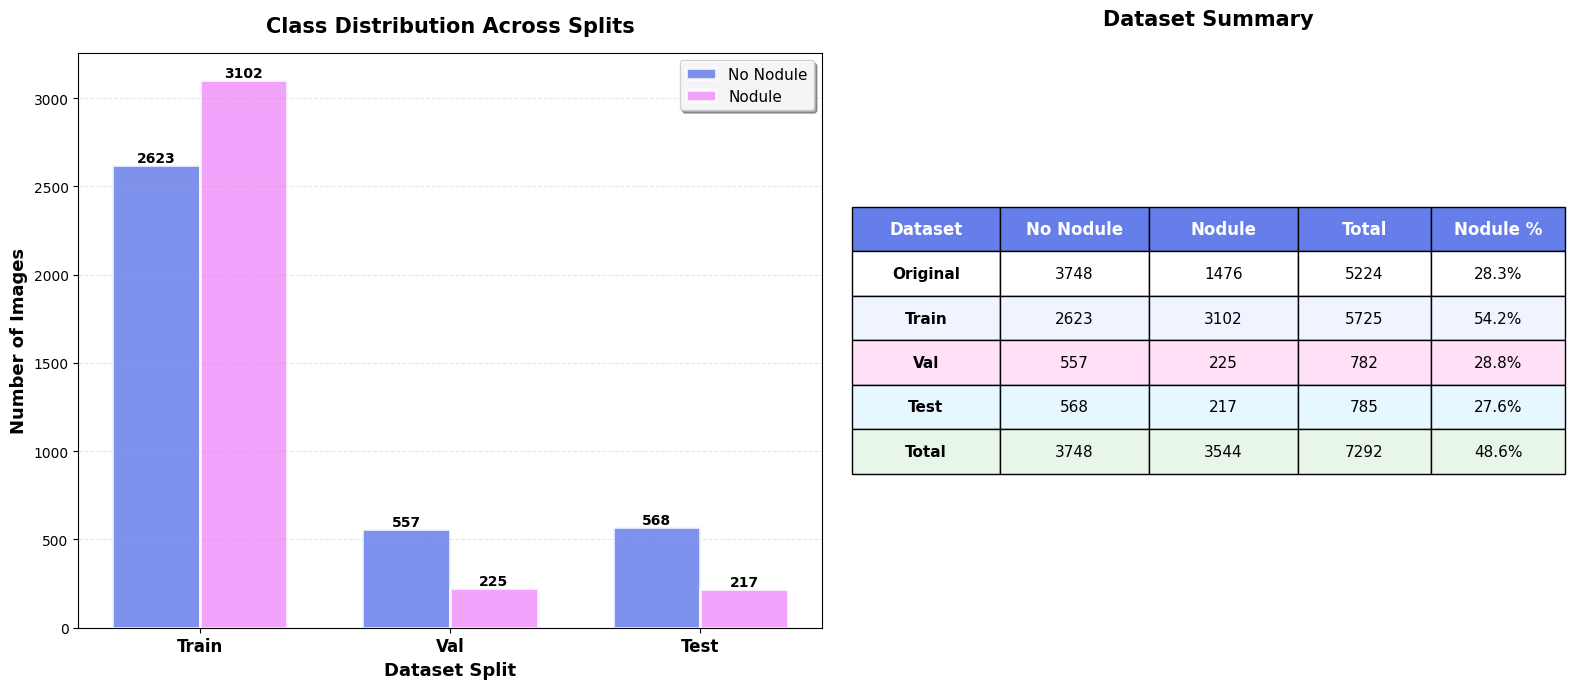

✓ Split distribution saved to 'split_distribution.png'


In [ ]:
# %% Figure 2: Train/Val/Test Distribution
fig2, axes = plt.subplots(1, 2, figsize=(16, 7))
fig2.patch.set_facecolor('white')

# Grouped bar chart
splits_data = {
    'Train': train_df['label'].value_counts().sort_index(),
    'Val': val_df['label'].value_counts().sort_index(),
    'Test': test_df['label'].value_counts().sort_index()
}

x = np.arange(len(splits_data))
width = 0.35
bars1 = axes[0].bar(x - width/2, [splits_data[k][0] for k in splits_data.keys()], 
                    width, label='No Nodule', color=color_negative, alpha=0.85, 
                    edgecolor='white', linewidth=2)
bars2 = axes[0].bar(x + width/2, [splits_data[k][1] for k in splits_data.keys()], 
                    width, label='Nodule', color=color_positive, alpha=0.85, 
                    edgecolor='white', linewidth=2)

axes[0].set_xlabel('Dataset Split', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Number of Images', fontsize=13, fontweight='bold')
axes[0].set_title('Class Distribution Across Splits', fontsize=15, fontweight='bold', pad=15)
axes[0].set_xticks(x)
axes[0].set_xticklabels(splits_data.keys(), fontsize=12, fontweight='bold')
axes[0].legend(fontsize=11, framealpha=0.9, shadow=True)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
axes[0].set_facecolor('#ffffff')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Summary table
summary_data = []
for split_name, split_df in [('Train', train_df), ('Val', val_df), ('Test', test_df), ('Total', combined_df)]:
    no_nodule = (split_df['label'] == 0).sum()
    nodule = (split_df['label'] == 1).sum()
    total = len(split_df)
    nodule_pct = f"{nodule/total*100:.1f}%" if total > 0 else "0%"
    summary_data.append([split_name, no_nodule, nodule, total, nodule_pct])

if has_original:
    # Add original row at the top
    orig_no_nodule = (original_df['label'] == 0).sum()
    orig_nodule = (original_df['label'] == 1).sum()
    orig_total = len(original_df)
    orig_pct = f"{orig_nodule/orig_total*100:.1f}%"
    summary_data.insert(0, ['Original', orig_no_nodule, orig_nodule, orig_total, orig_pct])

axes[1].axis('tight')
axes[1].axis('off')
table = axes[1].table(cellText=summary_data,
                      colLabels=['Dataset', 'No Nodule', 'Nodule', 'Total', 'Nodule %'],
                      cellLoc='center',
                      loc='center',
                      colWidths=[0.2, 0.2, 0.2, 0.18, 0.18])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

# Style header with gradient
for i in range(5):
    table[(0, i)].set_facecolor('#667eea')
    table[(0, i)].set_text_props(weight='bold', color='white', size=12)

# Alternate row colors
row_colors = ['#ffffff', '#f0f4ff', '#ffe0f7', '#e6f7ff', '#e8f5e9', '#fff3e0']
for i in range(1, len(summary_data) + 1):
    for j in range(5):
        table[(i, j)].set_facecolor(row_colors[(i-1) % len(row_colors)])
        table[(i, j)].set_text_props(weight='normal' if j > 0 else 'bold')

axes[1].set_title('Dataset Summary', fontsize=15, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('split_distribution.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Split distribution saved to 'split_distribution.png'")

In [ ]:
# %% Print detailed statistics
print("\n" + "="*70)
print("📊 DETAILED STATISTICS")
print("="*70)

if has_original:
    print("\nORIGINAL DATASET (Before Split):")
    print(f"   Total images: {len(original_df)}")
    print(f"   No Nodule (0): {original_counts[0]:,} ({original_counts[0]/len(original_df)*100:.1f}%)")
    print(f"   Nodule (1): {original_counts[1]:,} ({original_counts[1]/len(original_df)*100:.1f}%)")
    print(f"   Imbalance ratio: 1:{original_counts[0]/original_counts[1]:.2f}")

print("\nAFTER SPLIT & UPSAMPLE:")
print(f"   Total images (combined): {len(combined_df)}")
combined_counts = combined_df['label'].value_counts().sort_index()
print(f"   No Nodule (0): {combined_counts[0]:,} ({combined_counts[0]/len(combined_df)*100:.1f}%)")
print(f"   Nodule (1): {combined_counts[1]:,} ({combined_counts[1]/len(combined_df)*100:.1f}%)")
print(f"   Imbalance ratio: 1:{combined_counts[0]/combined_counts[1]:.2f}")

print("\nINDIVIDUAL SPLITS:")
train_counts = train_df['label'].value_counts().sort_index()
print(f"\n   Training Set ({len(train_df)} images):")
print(f"      No Nodule: {train_counts[0]:,} ({train_counts[0]/len(train_df)*100:.1f}%)")
print(f"      Nodule: {train_counts[1]:,} ({train_counts[1]/len(train_df)*100:.1f}%)")

val_counts = val_df['label'].value_counts().sort_index()
print(f"\n   Validation Set ({len(val_df)} images):")
print(f"      No Nodule: {val_counts[0]:,} ({val_counts[0]/len(val_df)*100:.1f}%)")
print(f"      Nodule: {val_counts[1]:,} ({val_counts[1]/len(val_df)*100:.1f}%)")

test_counts = test_df['label'].value_counts().sort_index()
print(f"\n   Test Set ({len(test_df)} images):")
print(f"      No Nodule: {test_counts[0]:,} ({test_counts[0]/len(test_df)*100:.1f}%)")
print(f"      Nodule: {test_counts[1]:,} ({test_counts[1]/len(test_df)*100:.1f}%)")

print("\n" + "="*70)
print("✨ All visualizations saved successfully!")
print("="*70)


📊 DETAILED STATISTICS

ORIGINAL DATASET (Before Split):
   Total images: 5224
   No Nodule (0): 3,748 (71.7%)
   Nodule (1): 1,476 (28.3%)
   Imbalance ratio: 1:2.54

AFTER SPLIT & UPSAMPLE:
   Total images (combined): 7292
   No Nodule (0): 3,748 (51.4%)
   Nodule (1): 3,544 (48.6%)
   Imbalance ratio: 1:1.06

INDIVIDUAL SPLITS:

   Training Set (5725 images):
      No Nodule: 2,623 (45.8%)
      Nodule: 3,102 (54.2%)

   Validation Set (782 images):
      No Nodule: 557 (71.2%)
      Nodule: 225 (28.8%)

   Test Set (785 images):
      No Nodule: 568 (72.4%)
      Nodule: 217 (27.6%)

✨ All visualizations saved successfully!


In [11]:
# Create datasets - each pointing to its own split directory
train_dataset = NoduleDataset(train_df, train_images_path, transform=train_transform)
val_dataset = NoduleDataset(val_df, val_images_path, transform=val_transform)
test_dataset = NoduleDataset(test_df, test_images_path, transform=val_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                         num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                       num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                        num_workers=NUM_WORKERS, pin_memory=True)

In [13]:
print("\nInitializing ResNet-50 model...")
model = timm.create_model('resnet50', pretrained=True, num_classes=2)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)


Initializing ResNet-50 model...


In [15]:
# %% Training Functions
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    pbar = tqdm(loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        probs = torch.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().detach().numpy())
        
        pbar.set_postfix({'loss': running_loss/len(loader), 'acc': 100.*correct/total})
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels, all_probs

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # probability of positive class

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    
    # Binary metrics
    binary_precision = precision_score(all_labels, all_preds, average='binary', zero_division=0)
    binary_recall = recall_score(all_labels, all_preds, average='binary', zero_division=0)
    binary_f1 = f1_score(all_labels, all_preds, average='binary', zero_division=0)
    binary_auc = roc_auc_score(all_labels, all_probs)
    
    return epoch_loss, epoch_acc, all_preds, all_labels, all_probs, binary_precision, binary_recall, binary_f1, binary_auc

In [ ]:
# Check for overlap
train_files = set(train_df['img_name'])
val_files = set(val_df['img_name'])
test_files = set(test_df['img_name'])

print(f"Train ∩ Val: {len(train_files & val_files)}")
print(f"Train ∩ Test: {len(train_files & test_files)}")
print(f"Val ∩ Test: {len(val_files & test_files)}")
# Should all be 0

Train ∩ Val: 0
Train ∩ Test: 0
Val ∩ Test: 0


In [ ]:
# %% Training Loop
print("\nStarting training...")
history = {
    'train_loss': [], 'train_acc': [], 'train_auc': [], 'train_precision': [],
    'val_loss': [], 'val_acc': [], 'val_auc': [], 'val_precision': []
}

best_val_acc = 0.0
best_model_path = 'best_resnet_nodule_model(NEW).pth'

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 50)
    
    # Train
    train_loss, train_acc, train_preds, train_labels, train_probs = train_epoch(
        model, train_loader, criterion, optimizer, device)
    
    # Calculate train metrics
    from sklearn.metrics import precision_score
    train_auc = roc_auc_score(train_labels, train_probs)
    train_precision = precision_score(train_labels, train_preds, average='binary', zero_division=0)
    
    # Validate
    val_loss, val_acc, val_preds, val_labels, val_probs = validate(
        model, val_loader, criterion, device)
    
    # Calculate val metrics
    val_auc = roc_auc_score(val_labels, val_probs)
    val_precision = precision_score(val_labels, val_preds, average='binary', zero_division=0)
    
    # Step scheduler
    scheduler.step()
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_auc'].append(train_auc)
    history['train_precision'].append(train_precision)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_auc'].append(val_auc)
    history['val_precision'].append(val_precision)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Train AUC: {train_auc:.4f}, Train Precision: {train_precision:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val AUC: {val_auc:.4f}, Val Precision: {val_precision:.4f}")
    print(f"LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_auc': val_auc,
        }, best_model_path)
        print(f"✓ Saved best model (Val Acc: {val_acc:.2f}%, Val AUC: {val_auc:.4f})")

print("\nTraining completed!")


Starting training...

Epoch 1/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:34<00:00,  1.41it/s]


Train Loss: 0.4725, Train Acc: 75.83%, Train AUC: 0.8683, Train Precision: 0.7263
Val Loss: 0.2838, Val Acc: 89.51%, Val AUC: 0.9548, Val Precision: 0.7826
LR: 0.000100
✓ Saved best model (Val Acc: 89.51%, Val AUC: 0.9548)

Epoch 2/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:15<00:00,  3.16it/s]


Train Loss: 0.2540, Train Acc: 89.55%, Train AUC: 0.9607, Train Precision: 0.9015
Val Loss: 0.2903, Val Acc: 85.04%, Val AUC: 0.9679, Val Precision: 0.9500
LR: 0.000098

Epoch 3/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:14<00:00,  3.41it/s]


Train Loss: 0.2034, Train Acc: 91.84%, Train AUC: 0.9746, Train Precision: 0.9243
Val Loss: 0.2393, Val Acc: 90.66%, Val AUC: 0.9836, Val Precision: 0.7676
LR: 0.000096
✓ Saved best model (Val Acc: 90.66%, Val AUC: 0.9836)

Epoch 4/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:14<00:00,  3.42it/s]


Train Loss: 0.1676, Train Acc: 93.75%, Train AUC: 0.9824, Train Precision: 0.9412
Val Loss: 0.3928, Val Acc: 83.12%, Val AUC: 0.9855, Val Precision: 0.6325
LR: 0.000094

Epoch 5/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:15<00:00,  3.13it/s]


Train Loss: 0.1408, Train Acc: 94.57%, Train AUC: 0.9877, Train Precision: 0.9451
Val Loss: 1.0513, Val Acc: 62.28%, Val AUC: 0.9855, Val Precision: 0.4327
LR: 0.000090

Epoch 6/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:14<00:00,  3.43it/s]


Train Loss: 0.1327, Train Acc: 95.23%, Train AUC: 0.9888, Train Precision: 0.9564
Val Loss: 0.3182, Val Acc: 86.32%, Val AUC: 0.9878, Val Precision: 0.9917
LR: 0.000086

Epoch 7/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:35<00:00,  1.38it/s]


Train Loss: 0.1050, Train Acc: 96.23%, Train AUC: 0.9931, Train Precision: 0.9619
Val Loss: 0.7833, Val Acc: 72.38%, Val AUC: 0.9845, Val Precision: 0.5102
LR: 0.000082

Epoch 8/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:31<00:00,  1.57it/s]


Train Loss: 0.1072, Train Acc: 96.31%, Train AUC: 0.9925, Train Precision: 0.9658
Val Loss: 0.3704, Val Acc: 84.78%, Val AUC: 0.9897, Val Precision: 0.9818
LR: 0.000077

Epoch 9/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:11<00:00,  4.27it/s]


Train Loss: 0.0816, Train Acc: 97.26%, Train AUC: 0.9954, Train Precision: 0.9724
Val Loss: 0.1369, Val Acc: 95.65%, Val AUC: 0.9906, Val Precision: 0.8898
LR: 0.000071
✓ Saved best model (Val Acc: 95.65%, Val AUC: 0.9906)

Epoch 10/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:14<00:00,  3.40it/s]


Train Loss: 0.0883, Train Acc: 97.03%, Train AUC: 0.9949, Train Precision: 0.9705
Val Loss: 0.1118, Val Acc: 96.16%, Val AUC: 0.9902, Val Precision: 0.9412
LR: 0.000065
✓ Saved best model (Val Acc: 96.16%, Val AUC: 0.9902)

Epoch 11/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:30<00:00,  1.60it/s]


Train Loss: 0.0615, Train Acc: 97.90%, Train AUC: 0.9976, Train Precision: 0.9800
Val Loss: 0.1475, Val Acc: 94.76%, Val AUC: 0.9917, Val Precision: 0.8651
LR: 0.000059

Epoch 12/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:20<00:00,  2.44it/s]


Train Loss: 0.0625, Train Acc: 97.62%, Train AUC: 0.9975, Train Precision: 0.9768
Val Loss: 0.2008, Val Acc: 91.82%, Val AUC: 0.9894, Val Precision: 0.9820
LR: 0.000053

Epoch 13/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:15<00:00,  3.27it/s]


Train Loss: 0.0536, Train Acc: 98.27%, Train AUC: 0.9981, Train Precision: 0.9833
Val Loss: 0.1098, Val Acc: 96.16%, Val AUC: 0.9924, Val Precision: 0.9665
LR: 0.000047

Epoch 14/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:31<00:00,  1.53it/s]


Train Loss: 0.0452, Train Acc: 98.32%, Train AUC: 0.9988, Train Precision: 0.9842
Val Loss: 0.1144, Val Acc: 96.29%, Val AUC: 0.9906, Val Precision: 0.9579
LR: 0.000041
✓ Saved best model (Val Acc: 96.29%, Val AUC: 0.9906)

Epoch 15/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:34<00:00,  1.40it/s]


Train Loss: 0.0428, Train Acc: 98.53%, Train AUC: 0.9989, Train Precision: 0.9849
Val Loss: 0.1133, Val Acc: 95.78%, Val AUC: 0.9919, Val Precision: 0.9486
LR: 0.000035

Epoch 16/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:37<00:00,  1.30it/s]


Train Loss: 0.0395, Train Acc: 98.67%, Train AUC: 0.9989, Train Precision: 0.9877
Val Loss: 0.0994, Val Acc: 96.04%, Val AUC: 0.9936, Val Precision: 0.9575
LR: 0.000029

Epoch 17/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:38<00:00,  1.28it/s]


Train Loss: 0.0415, Train Acc: 98.62%, Train AUC: 0.9988, Train Precision: 0.9865
Val Loss: 0.1045, Val Acc: 95.91%, Val AUC: 0.9940, Val Precision: 0.9573
LR: 0.000023

Epoch 18/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:15<00:00,  3.25it/s]


Train Loss: 0.0295, Train Acc: 99.13%, Train AUC: 0.9995, Train Precision: 0.9913
Val Loss: 0.1081, Val Acc: 96.42%, Val AUC: 0.9937, Val Precision: 0.9668
LR: 0.000018
✓ Saved best model (Val Acc: 96.42%, Val AUC: 0.9937)

Epoch 19/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:40<00:00,  1.20it/s]


Train Loss: 0.0311, Train Acc: 99.04%, Train AUC: 0.9994, Train Precision: 0.9913
Val Loss: 0.1250, Val Acc: 94.88%, Val AUC: 0.9939, Val Precision: 0.9695
LR: 0.000014

Epoch 20/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:34<00:00,  1.41it/s]


Train Loss: 0.0278, Train Acc: 98.95%, Train AUC: 0.9996, Train Precision: 0.9906
Val Loss: 0.1225, Val Acc: 95.27%, Val AUC: 0.9933, Val Precision: 0.9653
LR: 0.000010

Epoch 21/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:30<00:00,  1.60it/s]


Train Loss: 0.0285, Train Acc: 99.11%, Train AUC: 0.9994, Train Precision: 0.9916
Val Loss: 0.1016, Val Acc: 95.65%, Val AUC: 0.9945, Val Precision: 0.9614
LR: 0.000006

Epoch 22/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.53it/s]


Train Loss: 0.0270, Train Acc: 99.11%, Train AUC: 0.9996, Train Precision: 0.9894
Val Loss: 0.0993, Val Acc: 96.42%, Val AUC: 0.9947, Val Precision: 0.9624
LR: 0.000004

Epoch 23/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.56it/s]


Train Loss: 0.0227, Train Acc: 99.30%, Train AUC: 0.9998, Train Precision: 0.9942
Val Loss: 0.1150, Val Acc: 95.40%, Val AUC: 0.9944, Val Precision: 0.9610
LR: 0.000002

Epoch 24/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:17<00:00,  2.85it/s]


Train Loss: 0.0211, Train Acc: 99.39%, Train AUC: 0.9998, Train Precision: 0.9939
Val Loss: 0.1271, Val Acc: 95.14%, Val AUC: 0.9940, Val Precision: 0.9652
LR: 0.000000

Epoch 25/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:35<00:00,  1.37it/s]


Train Loss: 0.0304, Train Acc: 99.06%, Train AUC: 0.9993, Train Precision: 0.9907
Val Loss: 0.0936, Val Acc: 96.68%, Val AUC: 0.9942, Val Precision: 0.9628
LR: 0.000000
✓ Saved best model (Val Acc: 96.68%, Val AUC: 0.9942)

Training completed!


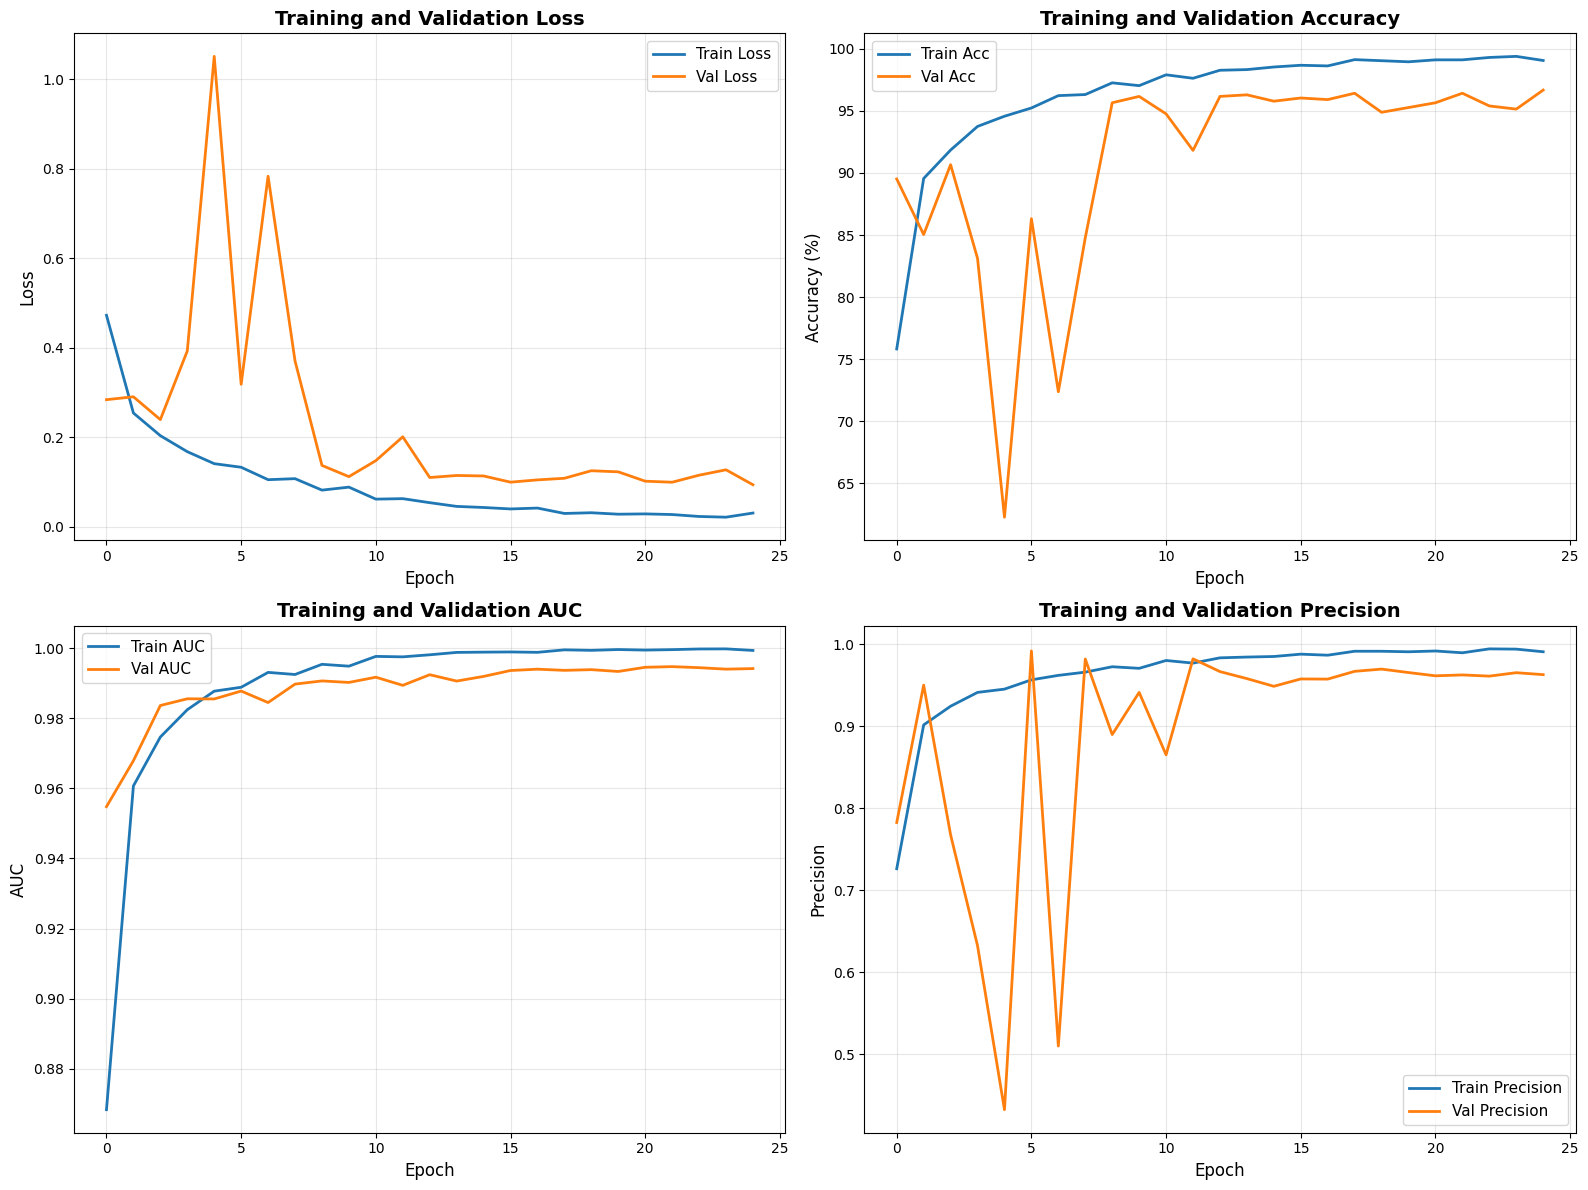

In [ ]:
# %% Plot Training History
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Loss plot
ax1.plot(history['train_loss'], label='Train Loss', linewidth=2)
ax1.plot(history['val_loss'], label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(history['train_acc'], label='Train Acc', linewidth=2)
ax2.plot(history['val_acc'], label='Val Acc', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

# AUC plot
ax3.plot(history['train_auc'], label='Train AUC', linewidth=2)
ax3.plot(history['val_auc'], label='Val AUC', linewidth=2)
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('AUC', fontsize=12)
ax3.set_title('Training and Validation AUC', fontsize=14, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)

# Precision plot
ax4.plot(history['train_precision'], label='Train Precision', linewidth=2)
ax4.plot(history['val_precision'], label='Val Precision', linewidth=2)
ax4.set_xlabel('Epoch', fontsize=12)
ax4.set_ylabel('Precision', fontsize=12)
ax4.set_title('Training and Validation Precision', fontsize=14, fontweight='bold')
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150)
plt.show()

In [ ]:
# %% Load Best Model and Evaluate on Test Set
print("\nLoading best model for testing...")
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])

test_loss, test_acc, test_preds, test_labels, test_probs = validate(model, test_loader, criterion, device)

print(f"\nTest Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=['No Nodule', 'Nodule']))

# ROC AUC Score
auc = roc_auc_score(test_labels, test_probs)
print(f"\nROC AUC Score: {auc:.4f}")


Loading best model for testing...


Validation: 100%|██████████| 50/50 [00:40<00:00,  1.22it/s]


Test Results:
Test Loss: 0.1362
Test Accuracy: 94.65%

Classification Report:
              precision    recall  f1-score   support

   No Nodule       0.95      0.98      0.96       568
      Nodule       0.94      0.86      0.90       217

    accuracy                           0.95       785
   macro avg       0.94      0.92      0.93       785
weighted avg       0.95      0.95      0.95       785


ROC AUC Score: 0.9885


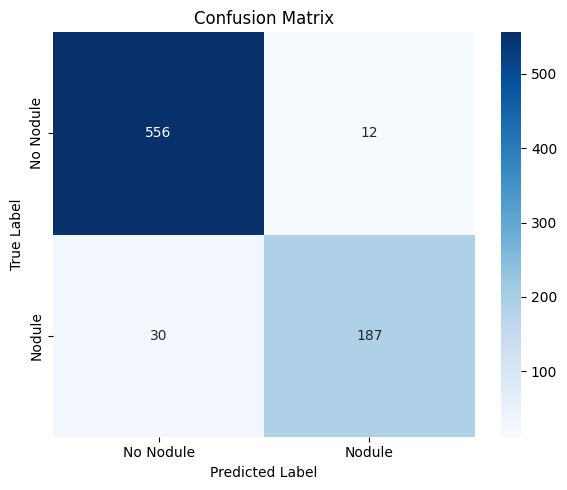

✓ Saved: confusion_matrix.png


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)
cm_labels = ['No Nodule', 'Nodule']

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_labels, yticklabels=cm_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()
print("✓ Saved: confusion_matrix.png")


In [16]:
# %% Load Best Model and Evaluate on Test Set
print("\nLoading best model for testing...")
best_model_path = 'best_resnet_nodule_model(NEW).pth'
model = timm.create_model('resnet50', pretrained=False, num_classes=2)
model = model.to(device)
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])

test_loss, test_acc, test_preds, test_labels, test_probs, test_prec, test_rec, test_f1, test_auc = validate(model, test_loader, criterion, device)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")
print(f"Test F1-score: {test_f1:.4f}")
print(f"Test ROC AUC: {test_auc:.4f}")

print(f"\n" + "="*70)
print("TEST SET RESULTS")
print("="*70)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=['No Nodule', 'Nodule']))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
print("\nConfusion Matrix:")
print(cm)


Loading best model for testing...


Validation: 100%|██████████| 50/50 [00:11<00:00,  4.24it/s]


Test Loss: 0.1362
Test Accuracy: 94.65%
Test Precision: 0.9397
Test Recall: 0.8618
Test F1-score: 0.8990
Test ROC AUC: 0.9885

TEST SET RESULTS
Test Loss: 0.1362
Test Accuracy: 94.65%

Classification Report:
              precision    recall  f1-score   support

   No Nodule       0.95      0.98      0.96       568
      Nodule       0.94      0.86      0.90       217

    accuracy                           0.95       785
   macro avg       0.94      0.92      0.93       785
weighted avg       0.95      0.95      0.95       785


Confusion Matrix:
[[556  12]
 [ 30 187]]
